# Getting Started

The main purpose of this tutorial is to ease the implementation of our library `scikit-activeml` to new users. `scikit-activeml` is a library that executes the most important query strategies. It is built upon the well-known machine learning frame-work `scikit-learn`, which makes it user-friendly. For better understanding, we show an exemplary active learning cycle here. Let's start by importing the relevant packages from both `scikit-learn` and `scikit-activeml`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utility

import warnings
warnings.filterwarnings("ignore")

## Data set Generation
We generate a data set of 100 data points with two clusters from the `make_classification` method of `scikit-learn`. This method also returns the true labels of each data point. In practice, however, we do not know these labels unless we ask an oracle. The labels are stored in `y_true`, which acts as an oracle.

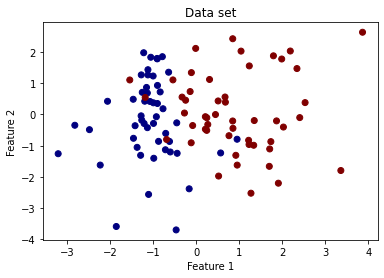

In [2]:
X, y_true = make_classification(n_features=2, n_redundant=0, random_state=0)
bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='jet')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data set');

## Classification
Our goal is to classify the data points into two classes. To do so, we introduce a vector `y` to store the labels that we acquire from the oracle (`y_true`). As shown below, the vector `y` is unlabeled at the beginning.

In [3]:
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
print(y)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


There are many easy-to-use classification algorithms in `scikit-learn`. In this example, we use the logistic regression classifier. Details of other classifiers can be accessed from here: https://scikit-activeml.readthedocs.io/en/latest/api/classifier.html. As `scikit-learn` classifiers cannot cope with missing labels, we need to wrap these with the `SklearnClassifier`.

In [4]:
clf = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

## Query Strategy
The query strategies are the central part of our library. In this example, we use uncertainty sampling with entropy to determine the most uncertain data points. All implemented strategies can be accessed from here: https://scikit-activeml.readthedocs.io/en/latest/api/pool.html.

In [5]:
qs = UncertaintySampling(method='entropy', random_state=42)

## Active Learning Cycle
In this example, we perform 20 iterations of the active learning cycle (`n_cycles=20`). In each iteration, we acquire one label (`batch_size=1`). The total number of labels to be acquired is `batch_size * n_cycles`. 
Inside the loop, we first get the indices of the unlabeled instances. In the first iteration, `unlbld_idx` contains all indices because all data points are unlabeled. Next, we use the unlabeled indices to create the list `X_cand` of candidate instances that can still be queried and ask the query strategy to give us the indices of the most informative data points in `X_cand`. The `query` method returns the indices of the best `batch_size` instances together with the corresponding instances. In our case, the output is just a single index, as `batch_size=1`.

Finally, we ask the oracle for the true label of the selected data point and store it in `y` to train our classifier. We continue until we reach the 20 labeled data points. 
Below, we see the implementation of an active learning cycle. The first figure shows the decision boundary after acquiring the label of two data points. The second figure shows the decision boundary with 10 acquired labels, which shows significant improvement compared to the first figure. The last figure shows the decision boundary after acquiring labels for 20 data points. Finally, we use the accuracy score as a performance measure, which shows the accuracy of our classifier in the specified iterations.

After 2 iterations:
The accuracy score is 0.5.
After 10 iterations:
The accuracy score is 0.93.
After 20 iterations:
The accuracy score is 0.94.


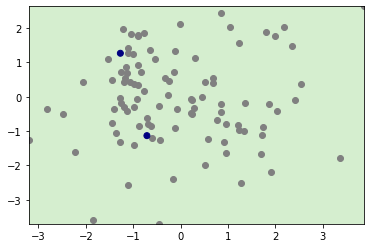

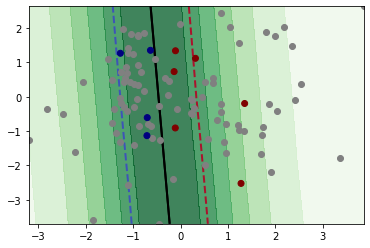

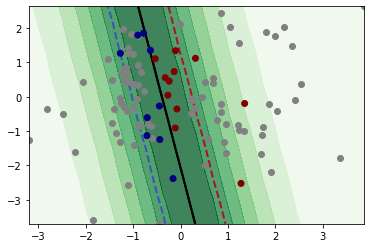

In [6]:
n_cycles = 20
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf.fit(X, y)
for c in range(n_cycles):
    unlbld_idx = unlabeled_indices(y)
    X_cand = X[unlbld_idx]
    cand_idx = qs.query(X_cand=X_cand, clf=clf, batch_size=1)
    query_idx = unlbld_idx[cand_idx]
    y[query_idx] = y_true[query_idx]
    clf.fit(X, y)
    
    # plotting
    unlbld_idx = unlabeled_indices(y)
    lbld_idx = labeled_indices(y)
    if len(lbld_idx) in [2, 10, 20]:
        print(f'After {len(lbld_idx)} iterations:')
        print(f'The accuracy score is {clf.score(X,y_true)}.')
        plot_utility(qs, {'clf': clf}, feature_bound=bound)
        plot_decision_boundary(clf, feature_bound=bound)
        plt.scatter(X[unlbld_idx,0], X[unlbld_idx,1], c='gray')
        plt.scatter(X[:,0], X[:,1], c=y, cmap='jet')
        plt.show()
